<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/quantized_autoencoder_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder for MNIST using binary latent code

Uses straight-through estimator to approximate the gradient.
Code is modified from
https://www.hassanaskary.com/python/pytorch/deep%20learning/2020/09/19/intuitive-explanation-of-straight-through-estimators.html


In [1]:
try:
    import torch
except ModuleNotFoundError:
    %pip install -qq torch
    import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

try:
    from torchvision import datasets, transforms
except ModuleNotFoundError:
    %pip install -qq torchvision
    from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

try:
    from tqdm import tqdm
except ModuleNotFoundError:
    %pip install -qq tqdm
    from tqdm import tqdm

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [2]:
# dataset preparation

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST("dataset/", train=True, download=True, transform=transform)
testset = datasets.MNIST("dataset/", train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [28]:
# defining networks


class STEFunction(autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return (input > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return F.hardtanh(grad_output)


class StraightThroughEstimator(nn.Module):
    def __init__(self):
        super(StraightThroughEstimator, self).__init__()

    def forward(self, x):
        x = STEFunction.apply(x)
        return x


nlatents = 256  # was originally 512


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, nlatents, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(nlatents),
            nn.ReLU(),
            StraightThroughEstimator(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(nlatents, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.Tanh(),
        )

    def forward(self, x, encode=False, decode=False):
        if encode:
            x = self.encoder(x)
        elif decode:
            x = self.decoder(x)
        else:
            encoding = self.encoder(x)
            x = self.decoder(encoding)
        return x


net = Autoencoder().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.5, 0.999))
criterion_MSE = nn.MSELoss().to(device)

In [29]:
# train loop

epoch = 5
for e in range(epoch):
    print(f"Starting epoch {e} of {epoch}")
    for X, y in tqdm(trainloader):
        optimizer.zero_grad()
        X = X.to(device)
        reconstruction = net(X)
        loss = criterion_MSE(reconstruction, X)
        loss.backward()
        optimizer.step()
    print(f"Loss: {loss.item()}")

Starting epoch 0 of 5


100%|██████████| 938/938 [00:17<00:00, 53.21it/s]


Loss: 0.048126302659511566
Starting epoch 1 of 5


100%|██████████| 938/938 [00:17<00:00, 53.61it/s]


Loss: 0.03352956101298332
Starting epoch 2 of 5


100%|██████████| 938/938 [00:17<00:00, 53.68it/s]


Loss: 0.03598036617040634
Starting epoch 3 of 5


100%|██████████| 938/938 [00:18<00:00, 51.94it/s]


Loss: 0.029913021251559258
Starting epoch 4 of 5


100%|██████████| 938/938 [00:17<00:00, 54.00it/s]

Loss: 0.02666076086461544


In [30]:
X, y = next(iter(testloader))
print([X.shape, y.shape])
X_in = X.to(device)
latent = net(X_in, encode=True).detach().cpu().numpy()
recon = net(X_in).detach().cpu().numpy()
print([latent.shape, recon.shape])

[torch.Size([64, 1, 28, 28]), torch.Size([64])]
[(64, 256, 1, 1), (64, 1, 28, 28)]


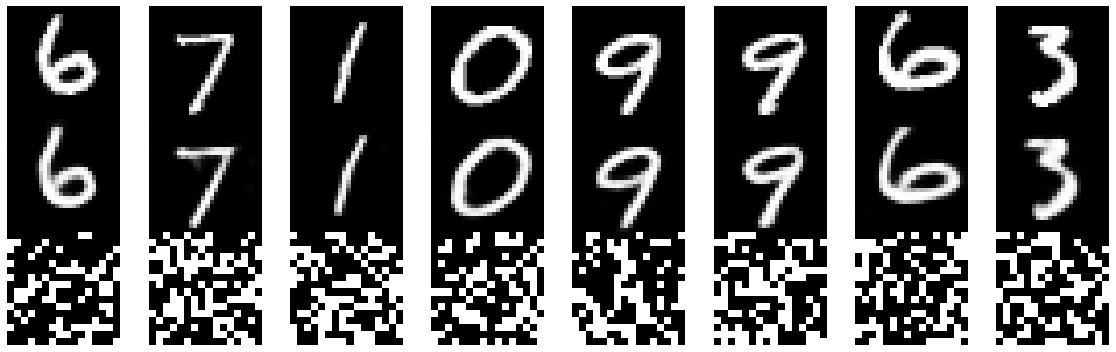

In [34]:
N = 8
fig, ax = plt.subplots(3, N, figsize=(2 * N, 5))
for i in range(N):
    ax[0, i].imshow(X[i].reshape((28, 28)), cmap="gray")
    ax[0, i].axis("off")

    ax[1, i].imshow(recon[i].reshape((28, 28)), cmap="gray")
    ax[1, i].axis("off")

    ax[2, i].imshow(latent[i].reshape((16, 16)), cmap="gray")
    ax[2, i].axis("off")
fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig("quantized_autoencoder_mnist.pdf")

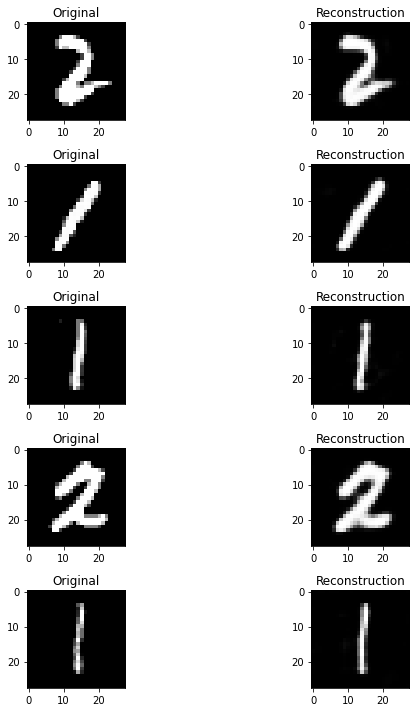

In [5]:
# original test loop

i = 1
fig = plt.figure(figsize=(10, 10))

for X, y in testloader:
    X_in = X.to(device)
    recon = net(X_in).detach().cpu().numpy()

    if i >= 10:
        break

    fig.add_subplot(5, 2, i).set_title("Original")
    plt.imshow(X[0].reshape((28, 28)), cmap="gray")
    fig.add_subplot(5, 2, i + 1).set_title("Reconstruction")
    plt.imshow(recon[0].reshape((28, 28)), cmap="gray")

    i += 2
fig.tight_layout()
plt.show()